# 森林火灾面积预测案例

森林火灾是一种突发性强、破坏性大、处置救助较为困难的自然灾害。森林火灾不仅烧毁林木，直接减少森林面积，而且严重破坏森林结构和森林环境，导致森林生态系统失去平衡，森林生物量下降，生产力减弱，益兽益鸟减少，甚至造成人畜伤亡。本案例通过探索性分析（EDA）和机器学习构建线性回归和决策树模型，预测森林火灾的面积，并分析什么特征是发生森林火灾的重要因素。

## 1 数据集描述与读取

我们采用2007年葡萄牙蒙特西尼奥公园森林火灾的相关数据。该数据集来自UCI机器学习库，数据中包含地理位置、天气等信息，具体的变量描述如下表所示：

| 量名 | 变量解释 |
|  ----  | ----  |
|X	| 公园地图的X轴空间坐标 |
|Y	| 公园地图的Y轴空间坐标 |
| month	| 火灾发生的月份 |
| day	| 火灾发生的星期 |
| FFMC	| FWI系统的FFMC指数 |
|DMC	|FWI系统的DMC指数|
|DC	|FWI系统的DC指数|
|ISI	|FWI系统的ISI指数|
|temp	|摄氏温度|
|RH	|相对湿度|
|wind	|风速|
|rain	|降雨量|
|area	|火灾面积|

其中FWI是指火险气候指数（Fire Weather Index）。FWI系统中，FFMC指数是细小可燃物湿度码，代表森林细小可燃物的含水率；DMC指数是粗腐殖质湿度码，代表森林腐殖质上层的地表可燃物的含水率；DC指数是干旱码，是长期干旱对森林可燃物的影响的指数；ISI指数是初始蔓延指数，代表了火势蔓延的等级。

进行数据分析之前，我们首先从文件中加载数据集：

In [1]:
# 忽略警告信息
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
fire = pd.read_csv('./forestfires.csv')

## 2 探索性数据分析

### 2.1 查看数据类型
使用info()函数输出数据集的基本信息，查看特征的类型：

In [2]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


从输出结果可以看出，该数据集一共有517条数据，包含13个变量，不存在缺失值。注意到month和day这两个特征不是数值型的数据，X、Y和RH这三个特征是整型数据，其余的特征是浮点型数据。

为了更具体地查看数据的形式，对数据集中的数据建立直观的感受，我们用head()函数输出数据集中的前5行数据：

In [3]:
fire.head()

X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0

从输出结果可以看出，month特征的数据是月份的小写英文缩写，day特征的数据则是星期的小写英文缩写。

### 2.2 数据的集中/离散趋势
下一步，我们用describe()函数查看数据集中火灾面积的基本统计信息，包括均值，标准差，最小值，最大值和四分位数，并存储在area_des中：

In [4]:
area_des = fire['area'].describe()
area_des

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

注意到火灾面积的标准差为63.66，与均值12.85相比过大，这说明数据之间的离散程度较大。


利用are_des中的数据，我们计算数据集中火灾面积数据的极差和四分位数间距：

In [5]:
area_range = area_des['max'] - area_des['min']
print("数据集中火灾面积数据的极差：",area_range)

quartile_deviation = area_des['75%'] - area_des['25%']
print("数据集中火灾面积数据的四分位数间距：", quartile_deviation)

数据集中火灾面积数据的极差： 1090.84
数据集中火灾面积数据的四分位数间距： 6.57


结果表明，数据集中火灾面积数据的极差很大，但四分位数间距很小，说明该列数据中存在一些离群点。

### 2.3 数据的分布与可视化
我们采用更直观的方法，将数据集中火灾面积这一列的数据通过直方图和箱线图进行展示，来查看数据的分布情况：

<AxesSubplot:title={'center':'histogram'}, ylabel='Frequency'>

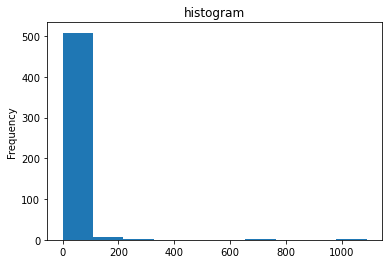

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False #用于在图中显示负号

# 通过分布直方图查看area列数据的分布情况
fire['area'].plot(kind='hist', title='histogram')

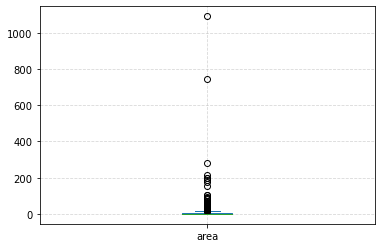

In [7]:
# 通过箱线图查看area列数据的分布情况
fire['area'].plot.box()
plt.grid(linestyle="--",  alpha=0.5)
plt.show()

从上图中我们可以看出，数据主要分布在0~200之间，但也有少量数据大于600，area数据中存在一些离群点。

下面，我们集中对刚刚发现的问题进行处理。首先，我们将数据集中火灾面积大于600的离群点去掉：

In [8]:
fire = fire[fire["area"]<600]

然后我们将month和day列的数据转换成数值型：

In [9]:
# 将月份转换成数值型
fire['month'] = fire['month'].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
                   'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})

# 将星期转换成数值型
fire['day'] = fire['day'].map({'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7})

# 查看转换后的数据
fire.head()

X  Y  month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5      3    5  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4     10    2  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4     10    6  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6      3    5  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6      3    7  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0

处理完毕后，我们将火灾面积大于0的数据从数据集中筛选出来，按月份分组，通过条形图和核密度图进行展示，查看在每个月份发生火灾的次数分布情况。

2     10
3     19
4      4
5      1
6      8
7     18
8     98
9     96
10     5
12     9
Name: month, dtype: int64


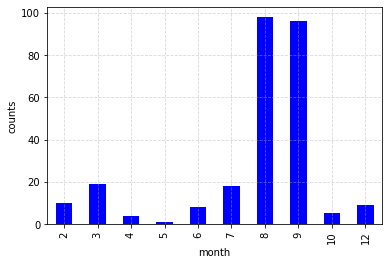

In [10]:
# 查看火灾面积不为0的数据
area_not_0 = fire[fire['area']!= 0]

#火灾发生时间的月份分布
month_counts = area_not_0['month'].value_counts()
month_counts.sort_index(inplace=True)
print(month_counts)

month_counts.plot(kind='bar', color = 'b')
plt.xlabel("month")
plt.ylabel("counts")
plt.grid(linestyle = '--', alpha = 0.5)
plt.show()

Text(0.5, 0, 'month')

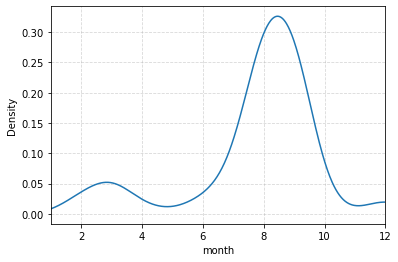

In [11]:
# 绘制火灾发生时间的月份分布的核密度图
area_not_0['month'].sort_index().plot(kind = 'kde')
plt.grid(linestyle = '--', alpha = 0.5)
plt.xlim(1,12)
plt.xlabel("month")

从两张图中可以看出，在8月份和9月份火灾发生的次数最多。

接着我们按星期进行分组，然后通过折线图进行展示，查看发生火灾的次数情况：

1    39
2    36
3    32
4    30
5    43
6    41
7    47
Name: day, dtype: int64


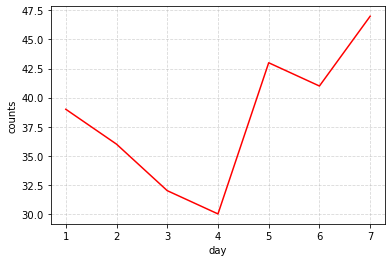

In [12]:
# 火灾发生时间的星期分布
day_counts = area_not_0['day'].value_counts()
day_counts.sort_index(inplace=True)
print(day_counts)

day_counts.plot(kind='line', color = 'r')
plt.grid(linestyle = '--', alpha = 0.5)
plt.xlabel("day")
plt.ylabel("counts")
plt.show()

从上图可以看出，在周五周六周日火灾发生的次数最多。

### 2.4 数据相关关系
最后，我们绘制火灾发生的面积与FWI系统的FFMC指数、DMC指数、DC指数、ISI指数之间的散点图，查看火灾发生的面积与这些指数之间的关系：

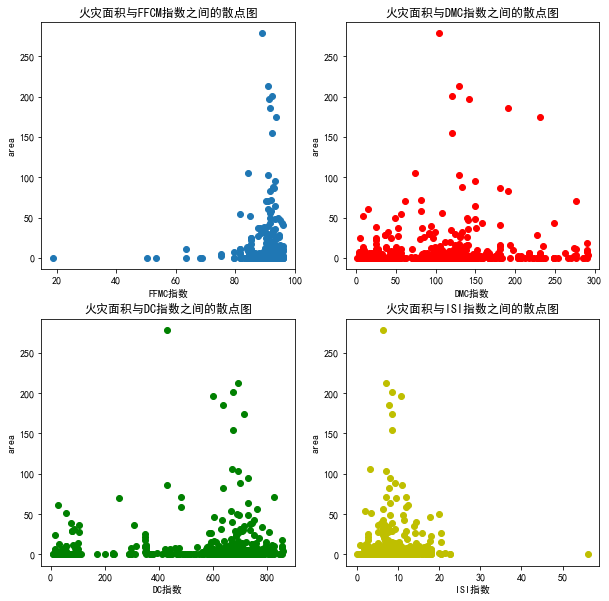

In [13]:
ffmc = fire["FFMC"]
dmc = fire["DMC"]
dc = fire["DC"]
isi = fire["ISI"]
area = fire['area']

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
ax1.scatter(ffmc, area)
ax1.set_xlabel("FFMC指数")
ax1.set_ylabel("area")
ax1.set_title("火灾面积与FFCM指数之间的散点图")

ax2 = fig.add_subplot(222)
ax2.scatter(dmc, area, color = 'r')
ax2.set_xlabel("DMC指数")
ax2.set_ylabel("area")
ax2.set_title("火灾面积与DMC指数之间的散点图")

ax3 = fig.add_subplot(223)
ax3.scatter(dc, area, color = 'g')
ax3.set_xlabel("DC指数")
ax3.set_ylabel("area")
ax3.set_title("火灾面积与DC指数之间的散点图")

ax4 = fig.add_subplot(224)
ax4.scatter(isi, area, color = 'y')
ax4.set_xlabel("ISI指数")
ax4.set_ylabel("area")
ax4.set_title("火灾面积与ISI指数之间的散点图")
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.show()

从上面的散点图中，我们发现火灾发生的面积与FFMC指数、DMC指数、DC指数、ISI指数之间并没有明显的相关性，下面我们通过计算火灾发生的面积与这些指数之间的Perason相关系数，通过相关系数查看数据之间的相关程度：

In [14]:
# 计算Pearson相关系数
corr_data = fire[['FFMC', 'DMC', 'DC', 'ISI', 'area']]
corr_data.corr()

FFMC       DMC        DC       ISI      area
FFMC  1.000000  0.381352  0.329709  0.531246  0.028390
DMC   0.381352  1.000000  0.682422  0.302777  0.067048
DC    0.329709  0.682422  1.000000  0.228377  0.044267
ISI   0.531246  0.302777  0.228377  1.000000 -0.029655
area  0.028390  0.067048  0.044267 -0.029655  1.000000

通过上面的相关系数矩阵，我们发现，火灾发生的面积与FFMC指数、DMC指数、DC指数、ISI指数之间并没有明显的相关性。但我们发现FFMC指数和ISI指数，DMC指数和DC指数之间的相关性较强。

## 3 机器学习方法
### 3.1 Min-Max标准化处理
我们使用sklearn中的MinMaxScaler方法，对数据集中除了X、Y、month、day之外的列做Min-Max标准化，使得处理后的数据取值分布在[0，1]区间上：

In [15]:
# 最小—最大标准化处理
from sklearn.preprocessing import MinMaxScaler
fire.iloc[:, 4:] = MinMaxScaler().fit_transform(fire.iloc[:, 4:])

In [16]:
# print(fire)

In [17]:
# 再次查看前5行
fire.head(5)

X  Y  month  day      FFMC       DMC        DC       ISI      temp  \
0  7  5      3    5  0.870968  0.086492  0.101325  0.090909  0.192926   
1  7  4     10    2  0.927742  0.118194  0.775419  0.119430  0.508039   
2  7  4     10    6  0.927742  0.146795  0.796294  0.119430  0.398714   
3  8  6      3    5  0.941935  0.110958  0.081623  0.160428  0.196141   
4  8  6      3    7  0.910968  0.172984  0.110590  0.171123  0.295820   

         RH      wind     rain  area  
0  0.423529  0.700000  0.00000   0.0  
1  0.211765  0.055556  0.00000   0.0  
2  0.211765  0.100000  0.00000   0.0  
3  0.964706  0.400000  0.03125   0.0  
4  0.988235  0.155556  0.00000   0.0

### 3.2 数据集划分
在训练模型之前需要将数据集划分为训练集和测试集，用训练集训练模型，用测试集评估模型：

In [18]:
# 数据集划分
# 目标特征分离
X = fire.iloc[:, :12]
y = fire['area']

# 将数据集划分为训练集和测试集，其中训练集占80%，测试集占20%
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print("训练集大小：",X_train.shape, "测试集大小：", X_test.shape)

训练集大小： (412, 12) 测试集大小： (103, 12)


In [19]:
X_train.head() #查看我们使用的训练集

X  Y  month  day      FFMC       DMC        DC       ISI      temp  \
102  2  4      8    2  0.981935  0.369400  0.749619  0.303030  0.575563   
81   1  2      8    7  0.922581  0.339421  0.730972  0.112299  0.504823   
311  6  3      9    7  0.950968  0.360786  0.879794  0.176471  0.726688   
181  8  6     10    1  0.854194  0.109235  0.769673  0.053476  0.543408   
378  6  5      3    4  0.931613  0.061337  0.026621  0.142602  0.209003   

           RH      wind  rain  
102  0.294118  0.400000   0.0  
81   0.341176  0.200000   0.0  
311  0.152941  0.155556   0.0  
181  0.200000  0.400000   0.0  
378  0.423529  0.600000   0.0

### 3.3 线性回归算法训练模型
我们使用线性回归算法训练模型，然后用训练的模型在测试集上进行火灾面积的预测，使用均方误差（MSE）评估模型的性能：


In [20]:
# 使用训练集训练模型并在测试集上测试模型的性能
from sklearn.linear_model import LinearRegression

# 使用线性回归训练模型
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
pre_LR = model_LR.predict(X_test)

# 在测试集上评估模型的性能
# 计算均方误差
from sklearn.metrics import mean_squared_error
mse_LR = mean_squared_error(pre_LR, y_test)

print(mse_LR)

0.0022308781960597096


In [21]:
from sklearn.metrics import r2_score

print(r2_score(y_test, pre_LR))

-0.33757405299345455


输出线性回归模型中的系数，并绘制模型中每个特征的系数图，查看在该模型中每个特征对火灾面积的影响程度：

In [22]:
# 输出模型系数
pd.Series(model_LR.coef_, index=X.columns)

X        0.002876
Y       -0.003931
month    0.008622
day     -0.000283
FFMC     0.022166
DMC      0.066513
DC      -0.088605
ISI     -0.150728
temp     0.073106
RH       0.004044
wind     0.004759
rain    -0.044853
dtype: float64

<AxesSubplot:>

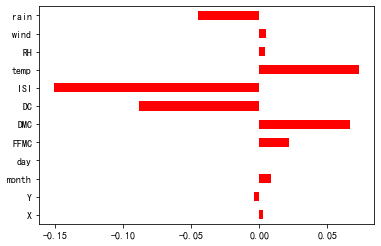

In [23]:
# 绘制模型中每个特征的系数图
pd.Series(model_LR.coef_, index=X.columns).plot(kind='barh', color='r')

### 3.4 决策树算法训练模型
我们使用决策树算法训练模型，然后用训练的模型在测试集上进行火灾面积的预测，使用均方误差（MSE）评估模型的性能：

In [24]:
# 构建决策树模型
# 使用训练集训练模型并在测试集上测试模型的性能
from sklearn.tree import DecisionTreeRegressor    # 回归
from sklearn.tree import DecisionTreeClassifier   # 分类

# 使用决策树构建模型
model_DF = DecisionTreeRegressor(max_depth=5, random_state=10)
model_DF.fit(X_train, y_train)  # 训练
pre_DF = model_DF.predict(X_test)  # 测试集上预测

# 在测试集上评估模型的性能
# 计算均方误差
mse_DF = mean_squared_error(pre_DF, y_test)

print(mse_DF)

0.02747029842788398


输出该决策树模型中的特征重要性，查看在该模型中每个特征对火灾面积的影响程度：

<AxesSubplot:>

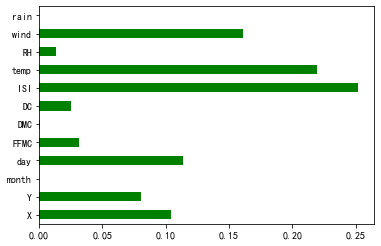

In [25]:
pd.Series(model_DF.feature_importances_, index=X.columns).plot(kind='barh', color='g')

通过上图，我们可以发现在构建的决策树模型中，影响火灾发生面积的最重要的特征是ISI指数和temp摄氏温度。

## 案例总结
本案例使用2007年葡萄牙蒙特西尼奥公园的相关数据进行森林火灾面积的预测，首先使用探索性数据分析探究数据集的基本情况、数据的分布情况以及数据之间的相关性等，然后使用线性回归和决策树进行模型的构建和模型的评估。